### Importing library


In [20]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

### Defineing diffusivity profile

In [34]:
import sympy
#sympy.init_printing()

z = sympy.symbols('z')

K0 = 0# e-3# m * * 2 / s
K1 = 5e-3# m / s
Aalpha = 0.5
c=4
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)# + K1/c*(1-sympy.tanh(c*z))
#sym_Diffu =  2e-3*sympy.cos(4/10*2*np.pi*z) + 3e-3
#sym_Diffu =  K0 + (10 * K1 )z + K1/c*(1-sympy.tanh(c*z))
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)


In [35]:
print(sym_Diffu)

0.005*z*exp(-0.5*z)


### Defineing lagrangian schemes

In [71]:
#######
#Euler#
#######
def step_e(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    
    a=0
    
    temp=z+a*dt+b*dW
    
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    
    predictor=(temp+z)/2
    
    b=np.sqrt(2*Diffu(predictor))
    temp=z+a*dt+b*dW
    
    temp=np.where(temp<0, -temp ,temp)
    nnntemp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_e_Test1(z,H,dt,N_sample):
    
    
    a=dKdz(z)
    
    temp=z+a*dt
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_e_Test2(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    b=np.sqrt(2*Diffu(z))
    
    temp=z+b*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

########
#Visser#
########
def step_v(z,H,dt,N_sample):
    
    dW=np.random.uniform(-1,1,N_sample)
    r=1/3
    #dW=np.random.normal(0,np.sqrt(dt),N_sample)
    #r=dt
    
    a=dKdz(z)
    G=Diffu(z+a*dt/2)
    
    temp= z + a*dt + np.sqrt(2/r*dt*G)*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_v_const(z,H,dt,N_sample):
    K0=3e-3
    
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    temp= z + np.sqrt(2/r*dt*K0)*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

##############
#Milstein 1nd#
##############
def step_m(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    b=Beta(z)
    db=dBdz(z)
    
    a_=Alpha(z)-(1/2)*b*db
    
    temp= z + a_*dt + b*dW  + (1/2)*b*db*dW*dW
    
    #temp= z + (1/2)*dKdz(z)*(dW*dW+dt) + Beta(z)*dW
    #temp= z + (1/2)*dKdz(z)*(dW*dW+dt) + Beta(z)*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

##############
#Milstein 2nd#
##############
def step_m2(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    ddkdz=dAdz(z)
    dddkdz=ddAdzz(z)
    sqrt2k=np.sqrt(2*k)
    
    a=dkdz
    da=ddkdz
    dda=dddkdz
    b= sqrt2k 
    db=dkdz/b
    ddb=ddkdz/b - ((dkdz)**2)/b**3
    ab=da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2
    
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_m2_const(z,H,dt,N_sample):
    
    K0=3e-3
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z +np.sqrt(2*K0)*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

### Defineing functions for time adaptive

In [72]:
def oneStep(upperBound, lowerBound, TimeAdaptive, scheme, rFactor ,H, dt):
    
    maskBody=((upperBound<TimeAdaptive)&(lowerBound>TimeAdaptive))

    zBody=TimeAdaptive[maskBody]
    zBody=scheme(zBody, H, dt, zBody.size)

    zEdge=TimeAdaptive[~maskBody]
    for j in range(rFactor):
        zEdge=scheme(zEdge,H,dt/rFactor,zEdge.size)

    TimeAdaptive[maskBody]=zBody
    TimeAdaptive[~maskBody]=zEdge
    
    return None

def parallelBodyEdge(Tmax, dt, H, prosent, rFactor, Testdepth, Np, Nbins,
                     queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const):
    np.random.seed()
    upperBound =H*prosent
    lowerBound =H-H*prosent
    Ntime   =int(Tmax/dt)  

    hist_E_timeAdap      =np.zeros((Nbins-1,),'i')
    hist_V_timeAdap      =np.zeros((Nbins-1,),'i')
    hist_M_timeAdap      =np.zeros((Nbins-1,),'i')
    hist_M2_timeAdap     =np.zeros((Nbins-1,),'i')
    hist_EConst_timeAdap =np.zeros((Nbins-1,),'i')
    hist_VConst_timeAdap =np.zeros((Nbins-1,),'i')
    hist_MConst_timeAdap =np.zeros((Nbins-1,),'i')

    zEulTimeAdaptive    =np.random.uniform(0,H,int(Np))
    zVisTimeAdaptive    =np.random.uniform(0,H,int(Np))
    zMilTimeAdaptive    =np.random.uniform(0,H,int(Np))
    zMil2TimeAdaptive   =np.random.uniform(0,H,int(Np))
    zEulConTimeAdaptive =np.random.uniform(0,H,int(Np))
    zVisConTimeAdaptive =np.random.uniform(0,H,int(Np))
    zMilConTimeAdaptive =np.random.uniform(0,H,int(Np))

    for i in range(Ntime):

        oneStep(upperBound, lowerBound, zEulTimeAdaptive,    step_e,        rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zVisTimeAdaptive,    step_v,        rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zMilTimeAdaptive,    step_m,        rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zMil2TimeAdaptive,   step_m2,       rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zEulConTimeAdaptive, step_e_const,  rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zVisConTimeAdaptive, step_v_const,  rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zMilConTimeAdaptive, step_m2_const, rFactor ,H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(zEulTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_E_timeAdap=hist_E_timeAdap + temp0

        temp1, _ = np.histogram(zVisTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_V_timeAdap=hist_V_timeAdap + temp1

        temp2, _ = np.histogram(zMilTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_M_timeAdap=hist_M_timeAdap + temp2

        temp3, _ = np.histogram(zMil2TimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_M2_timeAdap=hist_M2_timeAdap + temp3

        ### Constant potensial
        temp4, _ = np.histogram(zEulConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_EConst_timeAdap=hist_EConst_timeAdap+temp4

        temp5, _ = np.histogram(zVisConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_VConst_timeAdap=hist_VConst_timeAdap+temp5

        temp6, _ = np.histogram(zMilConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_MConst_timeAdap=hist_MConst_timeAdap+temp6

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    queneEu.put(hist_E_timeAdap)
    queneEuConst.put(hist_EConst_timeAdap)
    queneV.put(hist_V_timeAdap)
    queneVConst.put(hist_VConst_timeAdap)
    queneM.put(hist_M_timeAdap)
    queneM2.put(hist_M2_timeAdap)
    queneM2Const.put(hist_MConst_timeAdap)
            
    return None
        
def RunSimulation(NumberOfThread, Tmax, dt, H, prosent, rFactor, Testdepth, Np, Nbins):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter=Ntime

    if (__name__ == '__main__'):
        threads=[]
        queneEu=      mp.Queue()
        queneEuConst= mp.Queue()
        queneV=       mp.Queue()
        queneVConst=  mp.Queue()
        queneM=       mp.Queue()
        queneM2=      mp.Queue()
        queneM2Const= mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallelBodyEdge, 
                                args= (Tmax, dt, H, prosent, rFactor, Testdepth, SubNp[i], Nbins,
                                       queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const))
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_E_timeAdap      = np.zeros((Nbins-1,),'i')
    hist_EConst_timeAdap = np.zeros((Nbins-1,),'i')
    hist_V_timeAdap      = np.zeros((Nbins-1,),'i')
    hist_VConst_timeAdap = np.zeros((Nbins-1,),'i')
    hist_M_timeAdap      = np.zeros((Nbins-1,),'i')
    hist_M2_timeAdap     = np.zeros((Nbins-1,),'i')
    hist_MConst_timeAdap = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_E_timeAdap      += queneEu.get()
        hist_EConst_timeAdap += queneEuConst.get()
        hist_V_timeAdap      += queneV.get()
        hist_VConst_timeAdap += queneVConst.get()
        hist_M_timeAdap      += queneM.get()
        hist_M2_timeAdap     += queneM2.get()
        hist_MConst_timeAdap += queneM2Const.get()

    hist_E_timeAdap  =hist_E_timeAdap  /counter
    hist_V_timeAdap  =hist_V_timeAdap  /counter
    hist_M_timeAdap  =hist_M_timeAdap  /counter
    hist_M2_timeAdap =hist_M2_timeAdap /counter
    hist_EConst_timeAdap  =hist_EConst_timeAdap  /counter
    hist_VConst_timeAdap  =hist_VConst_timeAdap  /counter
    hist_MConst_timeAdap  =hist_MConst_timeAdap  /counter

    hist_E_timeAdap  =hist_E_timeAdap  /np.mean(hist_E_timeAdap)
    hist_V_timeAdap  =hist_V_timeAdap  /np.mean(hist_V_timeAdap)
    hist_M_timeAdap  =hist_M_timeAdap  /np.mean(hist_M_timeAdap)
    hist_M2_timeAdap =hist_M2_timeAdap /np.mean(hist_M2_timeAdap)
    hist_EConst_timeAdap  =hist_EConst_timeAdap  /np.mean(hist_EConst_timeAdap)
    hist_VConst_timeAdap  =hist_VConst_timeAdap  /np.mean(hist_VConst_timeAdap)
    hist_MConst_timeAdap  =hist_MConst_timeAdap  /np.mean(hist_MConst_timeAdap)
    
    lists=[]
    lists.append(hist_E_timeAdap)
    lists.append(hist_V_timeAdap)
    lists.append(hist_M_timeAdap)
    lists.append(hist_M2_timeAdap)
    lists.append(hist_EConst_timeAdap)
    lists.append(hist_VConst_timeAdap)
    lists.append(hist_MConst_timeAdap)
    
    return lists

In [73]:
# Criterion checking

z=np.linspace(0, 10,1000)
profile=dAdz(z)
Maxdt=(1/np.max(np.abs(profile)))
print(Maxdt)

200.0


### BinaryTimeApative Method

In [74]:
Np        = 40000
Nbins     = 600
Tmax      = 12*3600          #Maximum time
dt        = 10               #Delta time
H         = 10
prosent   = 0.1
rFactor   = 1
Testdepth = 0.25
NumberOfThread = 4

startTime=time()
lists = RunSimulation(NumberOfThread, Tmax, dt, H, prosent, rFactor, Testdepth, Np, Nbins)
endTime=time()
print("Time elapsed: ", endTime-startTime)

hist_E_timeAdap      = lists[0]
hist_V_timeAdap      = lists[1]
hist_M_timeAdap      = lists[2]
hist_M2_timeAdap     = lists[3]
hist_EConst_timeAdap = lists[4]
hist_VConst_timeAdap = lists[5]
hist_MConst_timeAdap = lists[6]

Total number of process:  4
Time elapsed:  81.48857641220093


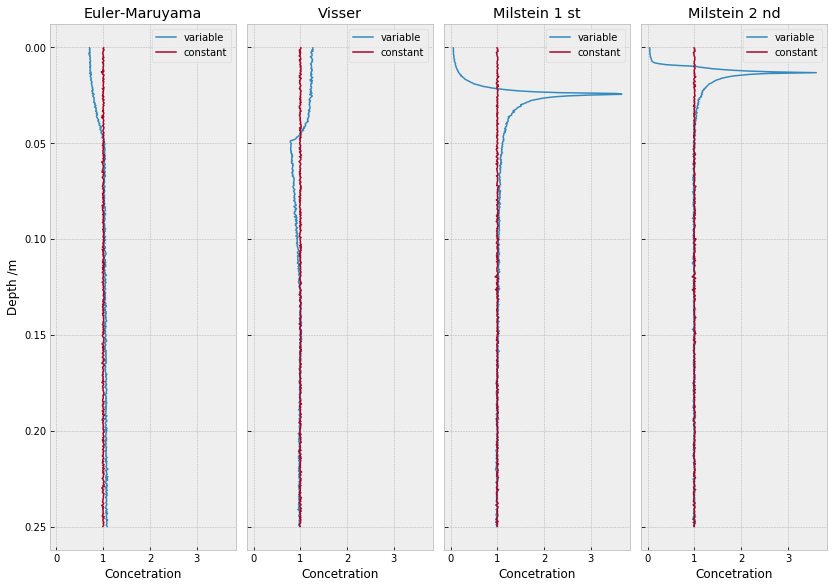

In [75]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27), sharey = True, sharex = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(hist_E_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(hist_EConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('Euler-Maruyama')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(hist_V_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(hist_VConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concetration')
ax[1].set_title('Visser')
ax[1].legend()

ax[2].plot(hist_M_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concetration')
ax[2].set_title('Milstein 1 st')
ax[2].legend()

ax[3].plot(hist_M2_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concetration')
ax[3].set_title('Milstein 2 nd')
#ax[3].set_xlim(0.95, 1.12)
ax[3].legend()

plt.tight_layout()
#plt.savefig("004.png")

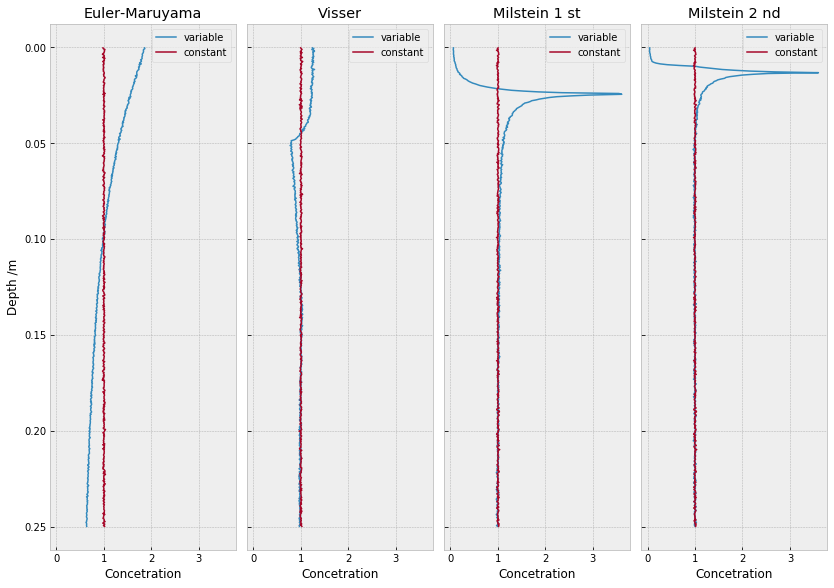

In [70]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27), sharey = True, sharex = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(hist_E_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(hist_EConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('Euler-Maruyama')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(hist_V_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(hist_VConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concetration')
ax[1].set_title('Visser')
ax[1].legend()

ax[2].plot(hist_M_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concetration')
ax[2].set_title('Milstein 1 st')
ax[2].legend()

ax[3].plot(hist_M2_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concetration')
ax[3].set_title('Milstein 2 nd')
#ax[3].set_xlim(0.95, 1.12)
ax[3].legend()

plt.tight_layout()
#plt.savefig("004.png")

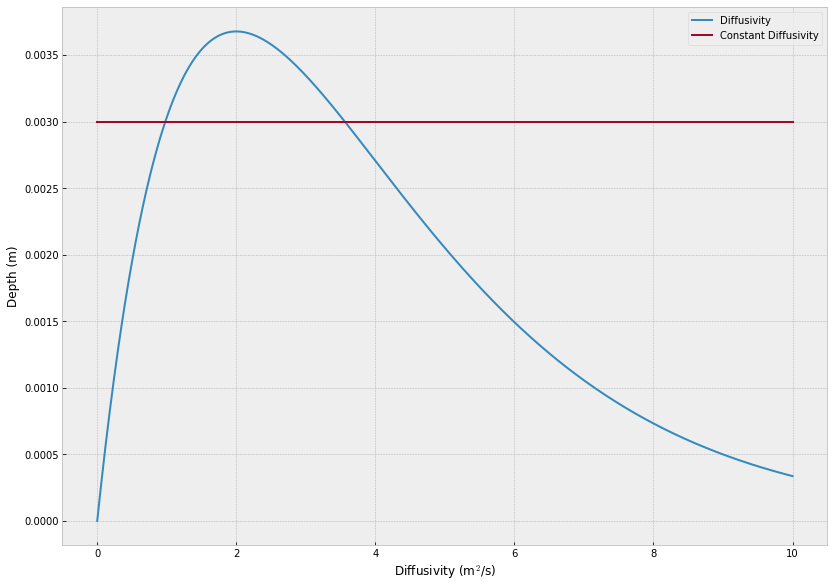

0.0


In [41]:
z=np.linspace(0, 10,1000)
profile=Diffu(z)
derivative=dKdz(z)
profile3=np.sqrt(2*profile)

Constant=z.copy()
Constant.fill(3e-3)

plt.figure(figsize=(11.69,8.27))
#plt.plot(z, profile, label="Diffusion")
plt.plot(z, profile, label="Diffusivity")
#plt.plot(z, derivative,  label="Derivative")
plt.plot(z, np.full(1000, 3e-3),  label="Constant Diffusivity")
#plt.gca().invert_yaxis()
plt.xlabel("Diffusivity (m$^2$/s)")
plt.ylabel("Depth (m)")
plt.tight_layout()
plt.legend()
plt.savefig("Diffusivity.png")
plt.show()

print(np.sqrt(2*Diffu(0)))

### Testing and finding the anormaly for Euler scheme

In [ ]:
H =10
x =0.2 #setting it to zero will make it disappears.
upperBound =H*x
lowerBound =H-H*x

T_Max   = 2
dt      = 1        #Delta time
rFactor = 2        #reduceFactor
Np      = 200000
binDepth= 4
Nbins   = 200
counter = 0

hist_E_timeAdap     =np.zeros((Nbins-1,),'i')
hist_EConst_timeAdap =np.zeros((Nbins-1,),'i')

zEulTimeAdaptive =np.random.uniform(0,H,int(Np))
zEulConTimeAdaptive =np.random.uniform(0,H,int(Np))

hist_body=0
hist_edge=0

loop=int(T_Max/dt)
for i in range(loop):
    
    ###Euler-Maruyama
    maskBody=((upperBound<zEulTimeAdaptive)&(lowerBound>zEulTimeAdaptive))
    
    zEBody=zEulTimeAdaptive[maskBody]
    zEBody=step_e(zEBody, H, dt, zEBody.size)
    
    temp, _ = np.histogram(zEBody, bins = np.linspace(0, binDepth, Nbins))
    hist_body+=temp
    
    zEEdge = zEulTimeAdaptive[~maskBody]
    #zEEdge=step_e_Test1(zEEdge,H,dt,zEEdge.size)
    
    for j in range(rFactor):
        zEEdge=step_e(zEEdge,H,dt/rFactor,zEEdge.size)
        #zEEdge=step_e_Test2(zEEdge,H,dt/rFactor,zEEdge.size)
        
    temp, _ = np.histogram(zEEdge, bins = np.linspace(0, binDepth, Nbins))
    hist_edge+=temp
    
    zEulTimeAdaptive[maskBody]=zEBody
    zEulTimeAdaptive[~maskBody]=zEEdge
        
    temp0, _ = np.histogram(zEulTimeAdaptive, bins = np.linspace(0, binDepth, Nbins))
    hist_E_timeAdap=temp0+hist_E_timeAdap
    
    if (loop>100 and (i % int(loop/100) ==0)): # Printing process
        print("\r %6.2f"% (i*100/loop+1),"%", end="\r",flush=True)
    
    counter=counter+1

hist_E_timeAdap  = hist_E_timeAdap  /np.mean(hist_E_timeAdap)
hist_body = hist_body/counter
hist_edge = hist_edge/counter

In [ ]:
bins = np.linspace(0, binDepth, Nbins)
midpoints = bins[: -1] + (bins[1] - bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69, 8.27))

ax[0].plot(hist_body, midpoints, lw = 1.5)
ax[0].invert_yaxis()

ax[1].plot(hist_edge, midpoints, lw = 1.5)
ax[1].invert_yaxis()

ax[2].plot(hist_body + hist_edge, midpoints, lw = 1.5)
#ax[2].set_xlim(390, 410)
ax[2].invert_yaxis()

ax[3].plot(hist_E_timeAdap, midpoints, lw = 1.5)
ax[3].invert_yaxis()

fig.subplots_adjust(hspace=0)
#plt.setp([ax[a].get_yticklabels() for a in range(1,4)], visible=False) 

fig.text(0.05, 0.35, "Depth: {:.1f}".format(binDepth), fontsize = 20)
fig.text(0.05, 0.30, "Bins: {:d}".format(Nbins), fontsize = 20)
fig.text(0.05, 0.25, "T_Max: {:d}".format(T_Max), fontsize = 20)
fig.text(0.05, 0.20, "dt: {:.1f}".format(dt), fontsize = 20)
fig.text(0.05, 0.15, "Factor: {:.2f}".format(rFactor), fontsize = 20)
fig.text(0.05, 0.10, "UpEdge: {:.2f}".format(upperBound), fontsize = 20)
fig.text(0.05, 0.05, "Par: {:d}".format(Np), fontsize = 20)

plt.tight_layout()
#plt.savefig(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

-3.090232306167813
3.090232306167813


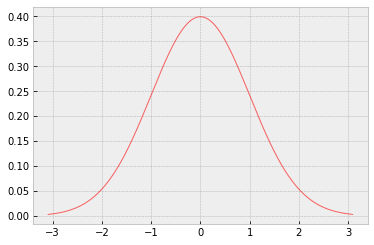

In [39]:
scale=1

x = np.linspace(norm.ppf(0.001, 0, scale),
                norm.ppf(0.999, 0, scale), 1000)

plt.plot(x, norm.pdf(x, 0, scale),
       'r-', lw=1, alpha=0.6, label='norm pdf')

print(norm.ppf(0.001, 0, scale))
print(norm.ppf(0.999, 0, scale))